In [47]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
import lightgbm as lgb
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Functions

In [3]:
def plot_permutation_importance(perm_dict, X, title):
    sorted_importances_idx = perm_dict["importances_mean"].argsort()
    importances = pd.DataFrame(
        perm_dict["importances"][sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(title)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Create a scorer object using the custom MAPE function
mape_scorer = make_scorer(mape, greater_is_better=False)

# Data preparation
In this notebook, we will be treating, scaling and overall preparing the data so that it can be trained on different models.

In [5]:
housePrices = pd.read_csv("csv_files/housePricesTrain.csv")
housePrices = housePrices.drop(columns=["Id"])

Based on previous analysis, we will be droping outlier values.

In [6]:
housePrices = housePrices[housePrices["SalePrice"] <= 450000]

In [7]:
X_reduced = housePrices.drop(columns=["SalePrice"])
y_train = housePrices["SalePrice"]

In [8]:
X_reduced = X_reduced.fillna(
    0
)  # Substituiremos os valores NaN por '0', para que a ordem seja preservada
# nas variáveis categóricas.

# Dicionário
mapping = {
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5,
    "No": 1,
    "Mn": 2,
    "Av": 3,
    "Unf": 1,
    "LwQ": 2,
    "Rec": 3,
    "BLQ": 4,
    "ALQ": 5,
    "GLQ": 6,
    "RFn": 2,
    "Fin": 3,
}
##
#       Ex   Excellent          GLQ   Good Living Quarters         Fin	Finished
#       Gd   Good               ALQ   Average Living Quarters      RFn	Rough Finished
#       TA   Average/Typical    Rec   Average Rec Room
##       Fa   Fair               LwQ   Low Quality
##       Po   Poor               Unf   Unfinished
##
##

X_reduced = X_reduced.replace(mapping)

#### One Hot Encoding

In [9]:
X_dummies = pd.get_dummies(X_reduced)

#### Scaling

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

### K-best

In [11]:
selector = SelectKBest(score_func=f_regression, k=20)


selector.fit(X_dummies, y_train)
selector.fit_transform(X_dummies, y_train)
selected = selector.get_support()

In [12]:
feature_scores = dict(zip(X_dummies.columns[selected], selector.scores_))

feature_scores_dict = pd.DataFrame.from_dict(
    feature_scores, orient="index"
).sort_values(by=0, ascending=False)
feature_scores_dict = feature_scores_dict.rename(columns={0: "ANOVA score"})

In [13]:
feature_scores_dict

,ANOVA score
MasVnrArea,2521.659557
1stFlrSF,1249.382006
FullBath,793.796820
Neighborhood_NridgHt,777.413344
BsmtQual,649.002390
TotalBsmtSF,579.493863
Foundation_PConc,352.503614
HeatingQC,327.089819
FireplaceQu,212.744691
TotRmsAbvGrd,199.798517


In [14]:
X_Kbest = X_dummies[X_dummies.columns[selected]]

In [15]:
X_Kbest

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,Neighborhood_NridgHt,Foundation_PConc
0,7,2003,2003,196.0,4,4,856,5,856,1710,2,4,8,0,0,2,2,548,0,1
1,6,1976,1976,0.0,3,4,1262,5,1262,1262,2,3,6,1,3,2,2,460,0,0
2,7,2001,2002,162.0,4,4,920,5,920,1786,2,4,6,1,3,2,2,608,0,1
3,7,1915,1970,0.0,3,3,756,4,961,1717,1,4,7,1,4,1,3,642,0,0
4,8,2000,2000,350.0,4,4,1145,5,1145,2198,2,4,9,1,3,2,3,836,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,0.0,3,4,953,5,953,1647,2,3,7,1,3,2,2,460,0,1
1456,6,1978,1988,119.0,3,4,1542,3,2073,2073,2,3,7,2,3,1,2,500,0,0
1457,7,1941,2006,0.0,5,3,1152,5,1188,2340,2,4,9,2,4,2,1,252,0,0
1458,5,1950,1996,0.0,3,3,1078,4,1078,1078,1,4,5,0,0,1,1,240,0,0


As a next step, we will be exploring the correlation between the K selected features. Our goal here is trying to spot any strong collinearity relationship.

In [16]:
correlations = X_Kbest.corr()

# Step 1: Drop diagonal entries
corr_df = correlations.where(
    np.triu(np.ones(correlations.shape), k=1).astype(np.bool)
)

# Step 2: Unstack to get a Series of correlation values
corr_series = corr_df.unstack()

# Step 3: Sort the Series in descending order
corr_series_sorted = corr_series.sort_values(ascending=False)

# Print the sorted correlation values
corr_series_sortedDF = pd.DataFrame(corr_series_sorted)

/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_45864/2875824191.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(correlations.shape), k=1).astype(np.bool)


<AxesSubplot: >

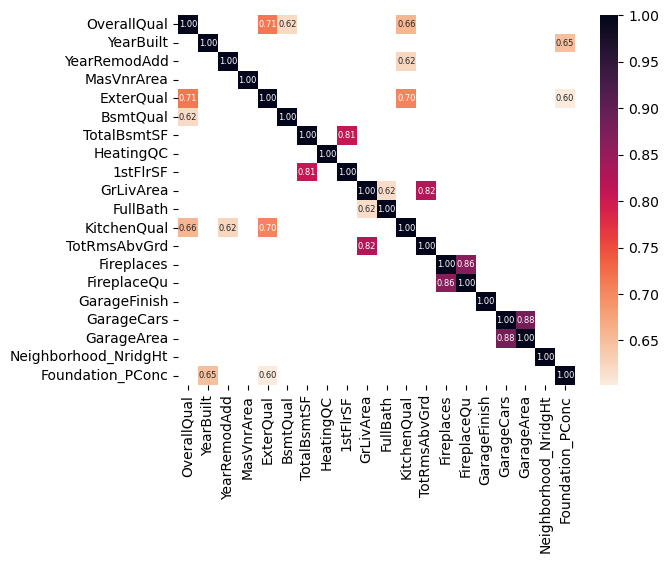

In [17]:
sns.heatmap(
    correlations,
    annot=True,
    cmap="rocket_r",
    fmt=".2f",
    annot_kws={"size": 6},
    mask=correlations < 0.6,
)

In [18]:
# mlflow.start_run(
#    run_name="RUN_1",
#    experiment_id=experiment_id,
#    tags={"version": "v1", "priority": "P1"},
#    description="KBestSelector",
# )

# Train

Mean average percentage error will be our standard metric.

In [19]:
scoring = {
    "R-squared": make_scorer(r2_score),
    "Adjusted R-squared": make_scorer(r2_score, greater_is_better=False),
    "Mape": mape_scorer,
}

# Linear Regression

We will start with a simple linear regression with ElasticNet penalty terms. This will serve as a baseline for comparison; Our goal is finding out what score can I get with the least amount of effort in terms of feature engineering. There will be a little bit of hyperparameter tinkering as I will be using gridsearch.

In [20]:
param_grid = {
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    "alpha": [1, 10, 100, 1000],
}

In [21]:
gridSearch = GridSearchCV(
    estimator=ElasticNet(max_iter=50000),
    param_grid=param_grid,
    scoring=scoring,
    verbose=3,
    n_jobs=-1,
    cv=5,
    refit="Mape",
)

In [22]:
gridSearch.fit(X_scaled, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV 1/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.892) Mape: (test=-9.172) R-squared: (test=0.892) total time=   0.1s
[CV 2/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.837) Mape: (test=-11.102) R-squared: (test=0.837) total time=   0.1s
[CV 4/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.886) Mape: (test=-9.672) R-squared: (test=0.886) total time=   0.1s
[CV 1/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (test=-0.898) Mape: (test=-9.094) R-squared: (test=0.898) total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (test=-0.890) Mape: (test=-9.446) R-squared: (test=0.890) total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.746) Mape: (test=-10.671) R-squared: (test=0.746) total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.847) Mape: (test=-10.254) R-squared: (test=0.847) total time=   0.1s
[CV 5/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (test=-0.7

In [23]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

gridSearch_results = pd.DataFrame(gridSearch.cv_results_)
gridSearch_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_R-squared,split1_test_R-squared,split2_test_R-squared,split3_test_R-squared,split4_test_R-squared,mean_test_R-squared,std_test_R-squared,rank_test_R-squared,split0_test_Adjusted R-squared,split1_test_Adjusted R-squared,split2_test_Adjusted R-squared,split3_test_Adjusted R-squared,split4_test_Adjusted R-squared,mean_test_Adjusted R-squared,std_test_Adjusted R-squared,rank_test_Adjusted R-squared,split0_test_Mape,split1_test_Mape,split2_test_Mape,split3_test_Mape,split4_test_Mape,mean_test_Mape,std_test_Mape,rank_test_Mape
0,0.067440,0.022774,0.003356,0.001273,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",0.892241,0.837254,0.847481,0.886263,0.746113,0.841870,0.052402,4,-0.892241,-0.837254,-0.847481,-0.886263,-0.746113,-0.841870,0.052402,17,-9.171965,-11.101695,-10.253828,-9.672421,-10.671097,-10.174202,0.688440,4
1,0.038308,0.006749,0.003257,0.002014,1,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",0.898202,0.842495,0.851388,0.889869,0.742379,0.844867,0.055537,3,-0.898202,-0.842495,-0.851388,-0.889869,-0.742379,-0.844867,0.055537,18,-9.093959,-10.979831,-10.140777,-9.445774,-10.558913,-10.043851,0.694368,3
2,0.037971,0.006514,0.002239,0.002011,1,0.5,"{'alpha': 1, 'l1_ratio': 0.5}",0.903991,0.847551,0.853727,0.892721,0.736115,0.846821,0.059463,1,-0.903991,-0.847551,-0.853727,-0.892721,-0.736115,-0.846821,0.059463,20,-9.056415,-10.878045,-10.045838,-9.320131,-10.455631,-9.951212,0.681372,2
3,0.047332,0.013470,0.002050,0.000969,1,0.7,"{'alpha': 1, 'l1_ratio': 0.7}",0.908932,0.852125,0.852133,0.894047,0.725042,0.846456,0.064767,2,-0.908932,-0.852125,-0.852133,-0.894047,-0.725042,-0.846456,0.064767,19,-9.076683,-10.778818,-10.007080,-9.386946,-10.484789,-9.946863,0.641227,1
4,0.051835,0.006752,0.001106,0.000090,1,0.9,"{'alpha': 1, 'l1_ratio': 0.9}",0.909323,0.854427,0.836400,0.891065,0.701880,0.838619,0.073078,6,-0.909323,-0.854427,-0.836400,-0.891065,-0.701880,-0.838619,0.073078,15,-9.479717,-10.862342,-10.197964,-9.861464,-10.980818,-10.276461,0.574902,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.006734,0.001900,0.002567,0.000247,1000,0.1,"{'alpha': 1000, 'l1_ratio': 0.1}",0.023207,0.017943,0.023292,0.007427,0.024914,0.019357,0.006411,20,-0.023207,-0.017943,-0.023292,-0.007427,-0.024914,-0.019357,0.006411,1,-33.199112,-37.229292,-33.860348,-35.039317,-32.598478,-34.385309,1.636544,20
16,0.005848,0.003317,0.001317,0.000590,1000,0.3,"{'alpha': 1000, 'l1_ratio': 0.3}",0.029846,0.023889,0.029567,0.014642,0.031557,0.025900,0.006194,19,-0.029846,-0.023889,-0.029567,-0.014642,-0.031557,-0.025900,0.006194,2,-33.062336,-37.087716,-33.728662,-34.899547,-32.472953,-34.250243,1.631856,19
17,0.003189,0.000248,0.000917,0.000030,1000,0.5,"{'alpha': 1000, 'l1_ratio': 0.5}",0.041572,0.034400,0.040649,0.027372,0.043275,0.037454,0.005866,18,-0.041572,-0.034400,-0.040649,-0.027372,-0.043275,-0.037454,0.005866,3,-32.819572,-36.836136,-33.494709,-34.653019,-32.250895,-34.010866,1.623429,18
18,0.004242,0.000484,0.000977,0.000033,1000,0.7,"{'alpha': 1000, 'l1_ratio': 0.7}",0.067860,0.058007,0.065490,0.055863,0.069490,0.063342,0.005426,17,-0.067860,-0.058007,-0.065490,-0.055863,-0.069490,-0.063342,0.005426,4,-32.269221,-36.271314,-32.966001,-34.096200,-31.747684,-33.470084,1.606347,17


In [24]:
gridSearch_results[
    ["mean_test_Mape", "mean_test_R-squared", "mean_test_Adjusted R-squared"]
]

,mean_test_Mape,mean_test_R-squared,mean_test_Adjusted R-squared
0,-10.174202,0.841870,-0.841870
1,-10.043851,0.844867,-0.844867
2,-9.951212,0.846821,-0.846821
3,-9.946863,0.846456,-0.846456
4,-10.276461,0.838619,-0.838619
...,...,...,...
15,-34.385309,0.019357,-0.019357
16,-34.250243,0.025900,-0.025900
17,-34.010866,0.037454,-0.037454
18,-33.470084,0.063342,-0.063342


In [48]:
-gridSearch.best_score_

9.94686309891823

In [26]:
gridSearch.best_estimator_.coef_

array([-1.97860524e+03,  6.19033685e+02,  3.43673727e+03,  8.02797138e+03,
        3.05406278e+03,  2.01298660e+03,  2.16727619e+03,  2.74465986e+03,
        3.44832290e+03, -5.27746685e+02,  3.27618488e+03, -8.14529608e+02,
        3.32525092e+03,  2.04281562e+03,  3.80899125e+03, -2.18134328e+02,
        5.32170788e+02, -3.24024910e+02,  3.85416787e+03,  1.27628510e+03,
        5.74975410e+03,  3.94521943e+03, -1.75299607e+02,  7.67089061e+03,
        2.32841534e+03, -2.58771980e+02,  2.24597904e+03,  1.64404174e+03,
       -1.31680845e+02, -1.32833231e+03,  4.06376566e+03,  4.06174697e+03,
        2.18369929e+03,  2.45665930e+03, -8.91111102e+02,  1.46885487e+03,
        4.04643890e+03,  4.36757430e+03,  4.78693573e+01, -1.09561372e+02,
        2.48966763e+03,  1.38955138e+03,  6.49954743e+02,  1.01719618e+03,
        1.16195180e+03,  6.03552472e+02, -4.41014700e+02,  3.77819953e+02,
       -1.32589318e+02, -2.84213518e+01, -2.00834124e+03,  7.30953419e+02,
        2.92877517e+02,  

In [27]:
# Access the coefficients of the best model
coefficients = gridSearch.best_estimator_.coef_

# Get the feature names
feature_names = X_dummies.columns

# Create a DataFrame to display the coefficients and corresponding feature names
coeff_df = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)

In [28]:
pd.set_option("display.max_rows", None)
coeff_df.sort_values(by="Coefficient", ascending=False)

,Feature,Coefficient
3,OverallQual,8027.971379
23,GrLivArea,7670.890607
20,1stFlrSF,5749.754099
94,Neighborhood_NridgHt,5423.989944
37,GarageArea,4367.574304
30,KitchenQual,4063.765664
31,TotRmsAbvGrd,4061.746969
36,GarageCars,4046.438901
21,2ndFlrSF,3945.219427
18,TotalBsmtSF,3854.167866


# Linear Regression - Kbest

In [29]:
X_Kbest = X_Kbest.assign(random=np.random.normal(size=X_Kbest.shape[0]))

In [30]:
KgridSearch = GridSearchCV(
    estimator=ElasticNet(max_iter=50000),
    param_grid=param_grid,
    scoring=scoring,
    verbose=3,
    n_jobs=-1,
    cv=5,
    refit="Mape",
)

In [31]:
KgridSearch.fit(X_Kbest, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.833) Mape: (test=-11.950) R-squared: (test=0.833) total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.789) Mape: (test=-13.017) R-squared: (test=0.789) total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.819) Mape: (test=-11.799) R-squared: (test=0.819) total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.832) Mape: (test=-12.481) R-squared: (test=0.832) total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (test=-0.591) Mape: (test=-14.373) R-squared: (test=0.591) total time=   0.0s
[CV 1/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (test=-0.836) Mape: (test=-11.894) R-squared: (test=0.836) total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (test=-0.791) Mape: (test=-13.109) R-squared: (test=0.791) total time=   0.0s


In [32]:
KgridSearch.best_score_

-12.653586219504751

In [33]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)


KgridSearch_results = pd.DataFrame(KgridSearch.cv_results_)
KgridSearch_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_R-squared,split1_test_R-squared,split2_test_R-squared,split3_test_R-squared,split4_test_R-squared,mean_test_R-squared,std_test_R-squared,rank_test_R-squared,split0_test_Adjusted R-squared,split1_test_Adjusted R-squared,split2_test_Adjusted R-squared,split3_test_Adjusted R-squared,split4_test_Adjusted R-squared,mean_test_Adjusted R-squared,std_test_Adjusted R-squared,rank_test_Adjusted R-squared,split0_test_Mape,split1_test_Mape,split2_test_Mape,split3_test_Mape,split4_test_Mape,mean_test_Mape,std_test_Mape,rank_test_Mape
0,0.003539,0.000366,0.001600,0.000063,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",0.833312,0.788706,0.819406,0.832329,0.591274,0.773006,0.092285,5,-0.833312,-0.788706,-0.819406,-0.832329,-0.591274,-0.773006,0.092285,16,-11.949772,-13.016661,-11.798584,-12.481237,-14.373252,-12.723901,0.929564,4
1,0.002716,0.000143,0.001559,0.000045,1,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",0.835642,0.791078,0.821103,0.834465,0.600196,0.776497,0.089602,4,-0.835642,-0.791078,-0.821103,-0.834465,-0.600196,-0.776497,0.089602,17,-11.894331,-13.109115,-11.767631,-12.402782,-14.236300,-12.682032,0.909146,2
2,0.002750,0.000402,0.001518,0.000039,1,0.5,"{'alpha': 1, 'l1_ratio': 0.5}",0.838222,0.793688,0.822739,0.836492,0.610971,0.780422,0.086215,3,-0.838222,-0.793688,-0.822739,-0.836492,-0.610971,-0.780422,0.086215,18,-11.861115,-13.238214,-11.759039,-12.328451,-14.081113,-12.653586,0.884710,1
3,0.002496,0.000219,0.001469,0.000080,1,0.7,"{'alpha': 1, 'l1_ratio': 0.7}",0.841134,0.796462,0.823942,0.837980,0.624345,0.784773,0.081750,2,-0.841134,-0.796462,-0.823942,-0.837980,-0.624345,-0.784773,0.081750,19,-11.953381,-13.468294,-11.846595,-12.299294,-13.887178,-12.690948,0.830128,3
4,0.002805,0.000183,0.001921,0.000767,1,0.9,"{'alpha': 1, 'l1_ratio': 0.9}",0.845265,0.799262,0.822847,0.837577,0.641469,0.789284,0.075553,1,-0.845265,-0.799262,-0.822847,-0.837577,-0.641469,-0.789284,0.075553,20,-12.138245,-13.837982,-12.103193,-12.414796,-13.641420,-12.827127,0.755454,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.010238,0.013277,0.011718,0.011461,1000,0.1,"{'alpha': 1000, 'l1_ratio': 0.1}",0.779095,0.729498,0.748916,0.755583,0.418364,0.686291,0.134898,20,-0.779095,-0.729498,-0.748916,-0.755583,-0.418364,-0.686291,0.134898,1,-13.367750,-14.369703,-14.332106,-14.811334,-16.471302,-14.670439,1.016353,20
16,0.006348,0.002024,0.007681,0.008801,1000,0.3,"{'alpha': 1000, 'l1_ratio': 0.3}",0.782445,0.733098,0.754277,0.761293,0.427836,0.691790,0.132915,19,-0.782445,-0.733098,-0.754277,-0.761293,-0.427836,-0.691790,0.132915,2,-13.200225,-14.128888,-14.118527,-14.676170,-16.323496,-14.489461,1.032306,19
17,0.006770,0.006795,0.001558,0.000120,1000,0.5,"{'alpha': 1000, 'l1_ratio': 0.5}",0.785936,0.737152,0.760518,0.767686,0.439439,0.698146,0.130295,18,-0.785936,-0.737152,-0.760518,-0.767686,-0.439439,-0.698146,0.130295,3,-13.070426,-13.896120,-13.841625,-14.510670,-16.168705,-14.297509,1.041296,18
18,0.005584,0.006092,0.001525,0.000121,1000,0.7,"{'alpha': 1000, 'l1_ratio': 0.7}",0.789159,0.741555,0.767707,0.774445,0.453727,0.705319,0.126737,17,-0.789159,-0.741555,-0.767707,-0.774445,-0.453727,-0.705319,0.126737,4,-13.065011,-13.692970,-13.544225,-14.359759,-16.066449,-14.145683,1.045918,17


In [34]:
pd.set_option("display.max_rows", None)

KgridSearch_results[
    ["mean_test_Mape", "mean_test_R-squared", "mean_test_Adjusted R-squared"]
]

,mean_test_Mape,mean_test_R-squared,mean_test_Adjusted R-squared
0,-12.723901,0.773006,-0.773006
1,-12.682032,0.776497,-0.776497
2,-12.653586,0.780422,-0.780422
3,-12.690948,0.784773,-0.784773
4,-12.827127,0.789284,-0.789284
5,-13.739536,0.732477,-0.732477
6,-13.643677,0.736326,-0.736326
7,-13.492324,0.742057,-0.742057
8,-13.221669,0.751591,-0.751591
9,-12.749628,0.771366,-0.771366


In [35]:
# Access the coefficients of the best model
Kcoefficients = KgridSearch.best_estimator_.coef_

# Get the feature names
Kfeature_names = X_Kbest.columns

# Create a DataFrame to display the coefficients and corresponding feature names
Kcoeff_df = pd.DataFrame(
    {"Feature": Kfeature_names, "Coefficient": Kcoefficients}
)

In [36]:
pd.set_option("display.max_rows", None)


Kcoeff_df \
.assign(absolute_coefficient=lambda df_: df_["Coefficient"].abs()) \
.sort_values(by="absolute_coefficient", ascending=True) \
.reset_index(drop=True)


,Feature,Coefficient,absolute_coefficient
0,TotalBsmtSF,12.532515,12.532515
1,1stFlrSF,13.007197,13.007197
2,MasVnrArea,22.087272,22.087272
3,GrLivArea,38.272475,38.272475
4,GarageArea,40.985647,40.985647
5,random,-144.584682,144.584682
6,YearBuilt,245.520636,245.520636
7,YearRemodAdd,338.336269,338.336269
8,TotRmsAbvGrd,459.360790,459.360790
9,FullBath,-607.363485,607.363485


In [37]:
from sklearn.inspection import permutation_importance

# Polynomial Regression - KBest

Polynomial Regression is very computionaly intensive. We will be restricting it to the dataset containing only the K-best features. It is also the occasion to use a simple pipeline.

In [38]:
poly_reg = make_pipeline(
    PolynomialFeatures(2),
    GridSearchCV(
        estimator=ElasticNet(max_iter=50000),
        param_grid=param_grid,
        scoring=scoring,
        verbose=3,
        n_jobs=-1,
        cv=5,
        return_train_score=True,
        refit="Mape"
    ),
)

In [39]:
poly_reg.fit(X_Kbest, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.020e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (train=-0.895, test=-0.870) Mape: (train=-10.238, test=-10.888) R-squared: (train=0.895, test=0.870) total time=  19.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (train=-0.895, test=-0.869) Mape: (train=-10.218, test=-10.931) R-squared: (train=0.895, test=0.869) total time=  19.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.860e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (train=-0.902, test=-0.811) Mape: (train=-10.000, test=-12.128) R-squared: (train=0.902, test=0.811) total time=  22.5s
[CV 3/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (train=-0.897, test=-0.862) Mape: (train=-10.145, test=-10.959) R-squared: (train=0.897, test=0.862) total time=  22.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (train=-0.898, test=-0.862) Mape: (train=-10.129, test=-10.962) R-squared: (train=0.898, test=0.862) total time=  22.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.672e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

[CV 4/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (train=-0.898, test=-0.852) Mape: (train=-10.009, test=-12.008) R-squared: (train=0.898, test=0.852) total time=  23.4s
[CV 2/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (train=-0.901, test=-0.741) Mape: (train=-9.524, test=-12.676) R-squared: (train=0.901, test=0.741) total time=  23.4s
[CV 2/5] END alpha=1, l1_ratio=0.1; Adjusted R-squared: (train=-0.900, test=-0.743) Mape: (train=-9.547, test=-12.648) R-squared: (train=0.900, test=0.743) total time=  23.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.992e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1, l1_ratio=0.5; Adjusted R-squared: (train=-0.896, test=-0.868) Mape: (train=-10.190, test=-10.985) R-squared: (train=0.896, test=0.868) total time=  24.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.851e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (train=-0.898, test=-0.851) Mape: (train=-9.985, test=-12.018) R-squared: (train=0.898, test=0.851) total time=  27.7s
[CV 5/5] END alpha=1, l1_ratio=0.3; Adjusted R-squared: (train=-0.903, test=-0.810) Mape: (train=-9.978, test=-12.146) R-squared: (train=0.903, test=0.810) total time=  27.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1, l1_ratio=0.7; Adjusted R-squared: (train=-0.897, test=-0.867) Mape: (train=-10.148, test=-11.065) R-squared: (train=0.897, test=0.867) total time=  24.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.660e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.896e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1, l1_ratio=0.5; Adjusted R-squared: (train=-0.901, test=-0.739) Mape: (train=-9.491, test=-12.712) R-squared: (train=0.901, test=0.739) total time=  28.1s
[CV 3/5] END alpha=1, l1_ratio=0.5; Adjusted R-squared: (train=-0.898, test=-0.862) Mape: (train=-10.106, test=-10.974) R-squared: (train=0.898, test=0.862) total time=  27.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1, l1_ratio=0.5; Adjusted R-squared: (train=-0.903, test=-0.807) Mape: (train=-9.947, test=-12.186) R-squared: (train=0.903, test=0.807) total time=  28.0s
[CV 4/5] END alpha=1, l1_ratio=0.5; Adjusted R-squared: (train=-0.899, test=-0.850) Mape: (train=-9.951, test=-12.036) R-squared: (train=0.899, test=0.850) total time=  28.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.639e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1, l1_ratio=0.7; Adjusted R-squared: (train=-0.902, test=-0.738) Mape: (train=-9.441, test=-12.779) R-squared: (train=0.902, test=0.738) total time=  28.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.011e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.875e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1, l1_ratio=0.7; Adjusted R-squared: (train=-0.900, test=-0.849) Mape: (train=-9.894, test=-12.068) R-squared: (train=0.900, test=0.849) total time=  28.5s
[CV 3/5] END alpha=1, l1_ratio=0.7; Adjusted R-squared: (train=-0.899, test=-0.862) Mape: (train=-10.072, test=-11.005) R-squared: (train=0.899, test=0.862) total time=  28.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.816e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1, l1_ratio=0.7; Adjusted R-squared: (train=-0.904, test=-0.802) Mape: (train=-9.898, test=-12.262) R-squared: (train=0.904, test=0.802) total time=  28.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.901e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1, l1_ratio=0.9; Adjusted R-squared: (train=-0.899, test=-0.863) Mape: (train=-10.094, test=-11.206) R-squared: (train=0.899, test=0.863) total time=  26.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1, l1_ratio=0.9; Adjusted R-squared: (train=-0.901, test=-0.861) Mape: (train=-9.998, test=-11.078) R-squared: (train=0.901, test=0.861) total time=  28.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.583e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1, l1_ratio=0.9; Adjusted R-squared: (train=-0.905, test=-0.744) Mape: (train=-9.334, test=-12.947) R-squared: (train=0.905, test=0.744) total time=  29.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1, l1_ratio=0.9; Adjusted R-squared: (train=-0.903, test=-0.843) Mape: (train=-9.779, test=-12.208) R-squared: (train=0.903, test=0.843) total time=  29.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.1; Adjusted R-squared: (train=-0.891, test=-0.875) Mape: (train=-10.394, test=-10.606) R-squared: (train=0.891, test=0.875) total time=  27.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1, l1_ratio=0.9; Adjusted R-squared: (train=-0.907, test=-0.784) Mape: (train=-9.780, test=-12.521) R-squared: (train=0.907, test=0.784) total time=  30.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=10, l1_ratio=0.1; Adjusted R-squared: (train=-0.898, test=-0.769) Mape: (train=-9.671, test=-12.416) R-squared: (train=0.898, test=0.769) total time=  29.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.1; Adjusted R-squared: (train=-0.895, test=-0.862) Mape: (train=-10.266, test=-10.982) R-squared: (train=0.895, test=0.862) total time=  30.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.3; Adjusted R-squared: (train=-0.891, test=-0.875) Mape: (train=-10.381, test=-10.628) R-squared: (train=0.891, test=0.875) total time=  26.9s
[CV 4/5] END alpha=10, l1_ratio=0.1; Adjusted R-squared: (train=-0.895, test=-0.854) Mape: (train=-10.179, test=-11.987) R-squared: (train=0.895, test=0.854) total time=  30.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.1; Adjusted R-squared: (train=-0.900, test=-0.819) Mape: (train=-10.141, test=-12.009) R-squared: (train=0.900, test=0.819) total time=  30.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=10, l1_ratio=0.3; Adjusted R-squared: (train=-0.898, test=-0.767) Mape: (train=-9.664, test=-12.435) R-squared: (train=0.898, test=0.767) total time=  30.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.5; Adjusted R-squared: (train=-0.892, test=-0.874) Mape: (train=-10.362, test=-10.659) R-squared: (train=0.892, test=0.874) total time=  24.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.968e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.3; Adjusted R-squared: (train=-0.895, test=-0.862) Mape: (train=-10.256, test=-10.983) R-squared: (train=0.895, test=0.862) total time=  28.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.911e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.3; Adjusted R-squared: (train=-0.900, test=-0.818) Mape: (train=-10.130, test=-12.022) R-squared: (train=0.900, test=0.818) total time=  28.5s
[CV 4/5] END alpha=10, l1_ratio=0.3; Adjusted R-squared: (train=-0.895, test=-0.854) Mape: (train=-10.168, test=-11.984) R-squared: (train=0.895, test=0.854) total time=  28.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.961e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.5; Adjusted R-squared: (train=-0.895, test=-0.862) Mape: (train=-10.241, test=-10.982) R-squared: (train=0.895, test=0.862) total time=  28.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=10, l1_ratio=0.5; Adjusted R-squared: (train=-0.898, test=-0.765) Mape: (train=-9.652, test=-12.464) R-squared: (train=0.898, test=0.765) total time=  29.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=10, l1_ratio=0.5; Adjusted R-squared: (train=-0.895, test=-0.854) Mape: (train=-10.149, test=-11.980) R-squared: (train=0.895, test=0.854) total time=  28.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.905e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.5; Adjusted R-squared: (train=-0.900, test=-0.818) Mape: (train=-10.113, test=-12.036) R-squared: (train=0.900, test=0.818) total time=  28.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.7; Adjusted R-squared: (train=-0.892, test=-0.873) Mape: (train=-10.331, test=-10.715) R-squared: (train=0.892, test=0.873) total time=  25.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=10, l1_ratio=0.7; Adjusted R-squared: (train=-0.899, test=-0.760) Mape: (train=-9.630, test=-12.512) R-squared: (train=0.899, test=0.760) total time=  31.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.027e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=10, l1_ratio=0.9; Adjusted R-squared: (train=-0.894, test=-0.870) Mape: (train=-10.248, test=-10.870) R-squared: (train=0.894, test=0.870) total time=  28.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.951e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.7; Adjusted R-squared: (train=-0.896, test=-0.862) Mape: (train=-10.217, test=-10.977) R-squared: (train=0.896, test=0.862) total time=  32.0s
[CV 4/5] END alpha=10, l1_ratio=0.7; Adjusted R-squared: (train=-0.896, test=-0.854) Mape: (train=-10.115, test=-11.978) R-squared: (train=0.896, test=0.854) total time=  32.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.894e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.7; Adjusted R-squared: (train=-0.901, test=-0.816) Mape: (train=-10.085, test=-12.059) R-squared: (train=0.901, test=0.816) total time=  32.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=10, l1_ratio=0.9; Adjusted R-squared: (train=-0.897, test=-0.862) Mape: (train=-10.154, test=-10.959) R-squared: (train=0.897, test=0.862) total time=  32.0s
[CV 2/5] END alpha=10, l1_ratio=0.9; Adjusted R-squared: (train=-0.900, test=-0.746) Mape: (train=-9.559, test=-12.628) R-squared: (train=0.900, test=0.746) total time=  32.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.076e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=10, l1_ratio=0.9; Adjusted R-squared: (train=-0.897, test=-0.852) Mape: (train=-10.022, test=-12.003) R-squared: (train=0.897, test=0.852) total time=  31.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.1; Adjusted R-squared: (train=-0.889, test=-0.877) Mape: (train=-10.459, test=-10.406) R-squared: (train=0.889, test=0.877) total time=  26.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=10, l1_ratio=0.9; Adjusted R-squared: (train=-0.902, test=-0.812) Mape: (train=-10.011, test=-12.117) R-squared: (train=0.902, test=0.812) total time=  30.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.014e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=100, l1_ratio=0.1; Adjusted R-squared: (train=-0.893, test=-0.863) Mape: (train=-10.291, test=-10.887) R-squared: (train=0.893, test=0.863) total time=  29.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.763e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.3; Adjusted R-squared: (train=-0.890, test=-0.877) Mape: (train=-10.455, test=-10.430) R-squared: (train=0.890, test=0.877) total time=  25.0s
[CV 2/5] END alpha=100, l1_ratio=0.1; Adjusted R-squared: (train=-0.897, test=-0.776) Mape: (train=-9.714, test=-12.253) R-squared: (train=0.897, test=0.776) total time=  30.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.1; Adjusted R-squared: (train=-0.893, test=-0.855) Mape: (train=-10.210, test=-12.011) R-squared: (train=0.893, test=0.855) total time=  28.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.960e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.1; Adjusted R-squared: (train=-0.899, test=-0.824) Mape: (train=-10.201, test=-11.799) R-squared: (train=0.899, test=0.824) total time=  29.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=100, l1_ratio=0.3; Adjusted R-squared: (train=-0.897, test=-0.776) Mape: (train=-9.711, test=-12.262) R-squared: (train=0.897, test=0.776) total time=  29.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=100, l1_ratio=0.3; Adjusted R-squared: (train=-0.894, test=-0.862) Mape: (train=-10.291, test=-10.901) R-squared: (train=0.894, test=0.862) total time=  29.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.5; Adjusted R-squared: (train=-0.890, test=-0.877) Mape: (train=-10.450, test=-10.462) R-squared: (train=0.890, test=0.877) total time=  24.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.183e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.3; Adjusted R-squared: (train=-0.893, test=-0.855) Mape: (train=-10.209, test=-12.015) R-squared: (train=0.893, test=0.855) total time=  29.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.954e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.3; Adjusted R-squared: (train=-0.899, test=-0.824) Mape: (train=-10.196, test=-11.830) R-squared: (train=0.899, test=0.824) total time=  28.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.004e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.755e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=100, l1_ratio=0.5; Adjusted R-squared: (train=-0.894, test=-0.862) Mape: (train=-10.291, test=-10.920) R-squared: (train=0.894, test=0.862) total time=  28.1s
[CV 2/5] END alpha=100, l1_ratio=0.5; Adjusted R-squared: (train=-0.897, test=-0.775) Mape: (train=-9.706, test=-12.279) R-squared: (train=0.897, test=0.775) total time=  28.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.5; Adjusted R-squared: (train=-0.893, test=-0.855) Mape: (train=-10.208, test=-12.018) R-squared: (train=0.893, test=0.855) total time=  28.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.7; Adjusted R-squared: (train=-0.890, test=-0.876) Mape: (train=-10.441, test=-10.504) R-squared: (train=0.890, test=0.876) total time=  24.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.947e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.5; Adjusted R-squared: (train=-0.899, test=-0.823) Mape: (train=-10.190, test=-11.869) R-squared: (train=0.899, test=0.823) total time=  27.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.748e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=100, l1_ratio=0.7; Adjusted R-squared: (train=-0.897, test=-0.774) Mape: (train=-9.697, test=-12.310) R-squared: (train=0.897, test=0.774) total time=  27.9s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=100, l1_ratio=0.9; Adjusted R-squared: (train=-0.891, test=-0.875) Mape: (train=-10.404, test=-10.590) R-squared: (train=0.891, test=0.875) total time=  24.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=100, l1_ratio=0.7; Adjusted R-squared: (train=-0.894, test=-0.862) Mape: (train=-10.289, test=-10.943) R-squared: (train=0.894, test=0.862) total time=  27.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.7; Adjusted R-squared: (train=-0.894, test=-0.854) Mape: (train=-10.208, test=-12.016) R-squared: (train=0.894, test=0.854) total time=  27.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.7; Adjusted R-squared: (train=-0.899, test=-0.822) Mape: (train=-10.180, test=-11.915) R-squared: (train=0.899, test=0.822) total time=  27.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.734e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=100, l1_ratio=0.9; Adjusted R-squared: (train=-0.898, test=-0.771) Mape: (train=-9.678, test=-12.385) R-squared: (train=0.898, test=0.771) total time=  27.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.145e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.979e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=100, l1_ratio=0.9; Adjusted R-squared: (train=-0.894, test=-0.854) Mape: (train=-10.187, test=-11.988) R-squared: (train=0.894, test=0.854) total time=  27.4s
[CV 3/5] END alpha=100, l1_ratio=0.9; Adjusted R-squared: (train=-0.895, test=-0.862) Mape: (train=-10.273, test=-10.976) R-squared: (train=0.895, test=0.862) total time=  28.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.213e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1000, l1_ratio=0.1; Adjusted R-squared: (train=-0.888, test=-0.881) Mape: (train=-10.512, test=-10.215) R-squared: (train=0.888, test=0.881) total time=  24.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=100, l1_ratio=0.9; Adjusted R-squared: (train=-0.900, test=-0.820) Mape: (train=-10.151, test=-11.999) R-squared: (train=0.900, test=0.820) total time=  26.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.811e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1000, l1_ratio=0.1; Adjusted R-squared: (train=-0.895, test=-0.781) Mape: (train=-9.757, test=-12.134) R-squared: (train=0.895, test=0.781) total time=  28.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1000, l1_ratio=0.1; Adjusted R-squared: (train=-0.892, test=-0.863) Mape: (train=-10.329, test=-10.815) R-squared: (train=0.892, test=0.863) total time=  27.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.267e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1000, l1_ratio=0.1; Adjusted R-squared: (train=-0.891, test=-0.860) Mape: (train=-10.250, test=-11.840) R-squared: (train=0.891, test=0.860) total time=  28.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.045e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1000, l1_ratio=0.1; Adjusted R-squared: (train=-0.897, test=-0.829) Mape: (train=-10.260, test=-11.793) R-squared: (train=0.897, test=0.829) total time=  28.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.203e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1000, l1_ratio=0.3; Adjusted R-squared: (train=-0.888, test=-0.881) Mape: (train=-10.506, test=-10.225) R-squared: (train=0.888, test=0.881) total time=  23.0s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.804e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1000, l1_ratio=0.3; Adjusted R-squared: (train=-0.895, test=-0.780) Mape: (train=-9.755, test=-12.154) R-squared: (train=0.895, test=0.780) total time=  26.3s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1000, l1_ratio=0.3; Adjusted R-squared: (train=-0.892, test=-0.863) Mape: (train=-10.324, test=-10.820) R-squared: (train=0.892, test=0.863) total time=  26.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1000, l1_ratio=0.5; Adjusted R-squared: (train=-0.888, test=-0.880) Mape: (train=-10.498, test=-10.241) R-squared: (train=0.888, test=0.880) total time=  22.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1000, l1_ratio=0.3; Adjusted R-squared: (train=-0.891, test=-0.860) Mape: (train=-10.245, test=-11.867) R-squared: (train=0.891, test=0.860) total time=  26.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1000, l1_ratio=0.5; Adjusted R-squared: (train=-0.896, test=-0.780) Mape: (train=-9.750, test=-12.176) R-squared: (train=0.896, test=0.780) total time=  25.1s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.033e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1000, l1_ratio=0.3; Adjusted R-squared: (train=-0.897, test=-0.828) Mape: (train=-10.251, test=-11.798) R-squared: (train=0.897, test=0.828) total time=  27.2s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1000, l1_ratio=0.5; Adjusted R-squared: (train=-0.892, test=-0.863) Mape: (train=-10.316, test=-10.825) R-squared: (train=0.892, test=0.863) total time=  25.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.244e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1000, l1_ratio=0.5; Adjusted R-squared: (train=-0.892, test=-0.859) Mape: (train=-10.238, test=-11.900) R-squared: (train=0.892, test=0.859) total time=  25.8s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1000, l1_ratio=0.7; Adjusted R-squared: (train=-0.889, test=-0.879) Mape: (train=-10.484, test=-10.270) R-squared: (train=0.889, test=0.879) total time=  21.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.018e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1000, l1_ratio=0.5; Adjusted R-squared: (train=-0.897, test=-0.828) Mape: (train=-10.241, test=-11.798) R-squared: (train=0.897, test=0.828) total time=  25.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1000, l1_ratio=0.7; Adjusted R-squared: (train=-0.896, test=-0.779) Mape: (train=-9.741, test=-12.203) R-squared: (train=0.896, test=0.779) total time=  24.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.045e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1000, l1_ratio=0.7; Adjusted R-squared: (train=-0.892, test=-0.863) Mape: (train=-10.307, test=-10.831) R-squared: (train=0.892, test=0.863) total time=  24.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1000, l1_ratio=0.7; Adjusted R-squared: (train=-0.892, test=-0.858) Mape: (train=-10.229, test=-11.941) R-squared: (train=0.892, test=0.858) total time=  24.7s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.000e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=1000, l1_ratio=0.7; Adjusted R-squared: (train=-0.898, test=-0.827) Mape: (train=-10.229, test=-11.787) R-squared: (train=0.898, test=0.827) total time=  24.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+11, tolerance: 5.643e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=1000, l1_ratio=0.9; Adjusted R-squared: (train=-0.889, test=-0.878) Mape: (train=-10.464, test=-10.362) R-squared: (train=0.889, test=0.878) total time=  20.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e+11, tolerance: 5.309e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1000, l1_ratio=0.9; Adjusted R-squared: (train=-0.896, test=-0.777) Mape: (train=-9.722, test=-12.235) R-squared: (train=0.896, test=0.777) total time=  19.4s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.024e+11, tolerance: 5.615e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1000, l1_ratio=0.9; Adjusted R-squared: (train=-0.893, test=-0.863) Mape: (train=-10.291, test=-10.870) R-squared: (train=0.893, test=0.863) total time=  19.6s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.200e+11, tolerance: 5.915e+08
  model = cd_fast.enet_coordinate_descent(
/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.970e+11, tolerance: 5.794e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=1000, l1_ratio=0.9; Adjusted R-squared: (train=-0.893, test=-0.856) Mape: (train=-10.211, test=-11.997) R-squared: (train=0.893, test=0.856) total time=  18.1s
[CV 5/5] END alpha=1000, l1_ratio=0.9; Adjusted R-squared: (train=-0.898, test=-0.825) Mape: (train=-10.212, test=-11.778) R-squared: (train=0.898, test=0.825) total time=  17.5s


/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.987e+11, tolerance: 7.070e+08
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=ElasticNet(max_iter=50000),
                              n_jobs=-1,
                              param_grid={'alpha': [1, 10, 100, 1000],
                                          'l1_ratio': [0.1, 0.3, 0.5, 0.7,
                                                       0.9]},
                              refit='Mape', return_train_score=True,
                              scoring={'Adjusted R-squared': make_scorer(r2_score, greater_is_better=False),
                                       'Mape': make_scorer(mape, greater_is_better=False),
                                       'R-squared': make_scorer(r2_score)},
                              verbose=3))])

In [40]:
estimator = poly_reg.named_steps["gridsearchcv"]
pd.DataFrame(estimator.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_R-squared,split1_test_R-squared,split2_test_R-squared,split3_test_R-squared,split4_test_R-squared,mean_test_R-squared,std_test_R-squared,rank_test_R-squared,split0_train_R-squared,split1_train_R-squared,split2_train_R-squared,split3_train_R-squared,split4_train_R-squared,mean_train_R-squared,std_train_R-squared,split0_test_Adjusted R-squared,split1_test_Adjusted R-squared,split2_test_Adjusted R-squared,split3_test_Adjusted R-squared,split4_test_Adjusted R-squared,mean_test_Adjusted R-squared,std_test_Adjusted R-squared,rank_test_Adjusted R-squared,split0_train_Adjusted R-squared,split1_train_Adjusted R-squared,split2_train_Adjusted R-squared,split3_train_Adjusted R-squared,split4_train_Adjusted R-squared,mean_train_Adjusted R-squared,std_train_Adjusted R-squared,split0_test_Mape,split1_test_Mape,split2_test_Mape,split3_test_Mape,split4_test_Mape,mean_test_Mape,std_test_Mape,rank_test_Mape,split0_train_Mape,split1_train_Mape,split2_train_Mape,split3_train_Mape,split4_train_Mape,mean_train_Mape,std_train_Mape
0,22.316146,1.463502,0.010546,0.003140,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",0.869888,0.743469,0.861695,0.852084,0.811486,0.827724,0.046665,16,0.894580,0.900298,0.897308,0.897762,0.902489,0.898488,0.002701,-0.869888,-0.743469,-0.861695,-0.852084,-0.811486,-0.827724,0.046665,5,-0.894580,-0.900298,-0.897308,-0.897762,-0.902489,-0.898488,0.002701,-10.888462,-12.648174,-10.958588,-12.007608,-12.127554,-11.726077,0.690122,16,-10.237858,-9.547106,-10.145319,-10.009370,-9.999993,-9.987929,0.237557
1,24.268496,3.033492,0.006834,0.001421,1,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",0.869113,0.741084,0.861684,0.851456,0.809980,0.826663,0.047424,17,0.895082,0.900721,0.897700,0.898291,0.902889,0.898937,0.002669,-0.869113,-0.741084,-0.861684,-0.851456,-0.809980,-0.826663,0.047424,4,-0.895082,-0.900721,-0.897700,-0.898291,-0.902889,-0.898937,0.002669,-10.930817,-12.676096,-10.961710,-12.018378,-12.145872,-11.746574,0.689754,17,-10.217546,-9.524290,-10.129064,-9.985047,-9.978091,-9.966808,0.238947
2,27.193180,1.582184,0.010249,0.004123,1,0.5,"{'alpha': 1, 'l1_ratio': 0.5}",0.868076,0.738926,0.861647,0.850447,0.807500,0.825319,0.048084,18,0.895785,0.901345,0.898265,0.899051,0.903467,0.899583,0.002632,-0.868076,-0.738926,-0.861647,-0.850447,-0.807500,-0.825319,0.048084,3,-0.895785,-0.901345,-0.898265,-0.899051,-0.903467,-0.899583,0.002632,-10.984671,-12.711757,-10.973548,-12.036072,-12.186334,-11.778476,0.690181,18,-10.189542,-9.490559,-10.106382,-9.951031,-9.947120,-9.936927,0.241693
3,27.714059,1.808749,0.012888,0.006467,1,0.7,"{'alpha': 1, 'l1_ratio': 0.7}",0.866537,0.738057,0.861521,0.848559,0.802402,0.823415,0.048314,19,0.896905,0.902402,0.899199,0.900305,0.904426,0.900647,0.002592,-0.866537,-0.738057,-0.861521,-0.848559,-0.802402,-0.823415,0.048314,2,-0.896905,-0.902402,-0.899199,-0.900305,-0.904426,-0.900647,0.002592,-11.065453,-12.778770,-11.005034,-12.067780,-12.262275,-11.835862,0.694045,19,-10.147777,-9.440836,-10.071942,-9.893877,-9.898389,-9.890564,0.245513
4,28.559908,1.408317,0.016582,0.010552,1,0.9,"{'alpha': 1, 'l1_ratio': 0.9}",0.863487,0.743911,0.860902,0.843338,0.784047,0.819137,0.047301,20,0.899348,0.904956,0.901349,0.903219,0.906691,0.903113,0.002588,-0.863487,-0.743911,-0.860902,-0.843338,-0.784047,-0.819137,0.047301,1,-0.899348,-0.904956,-0.901349,-0.903219,-0.906691,-0.903113,0.002588,-11.205710,-12.947205,-11.078321,-12.207591,-12.521246,-11.992015,0.733765,20,-10.093616,-9.333925,-9.997867,-9.778610,-9.779838,-9.796771,0.262069
5,29.727783,1.112045,0.011597,0.003427,10,0.1,"{'alpha': 10, 'l1_ratio': 0.1}",0.875116,0.769033,0.861538,0.853966,0.819105,0.835752,0.038144,11,0.891086,0.897988,0.894816,0.894574,0.900053,0.895704,0.003083,-0.875116,-0.769033,-0.861538,-0.853966,-0.819105,-0.835752,0.038144,10,-0.891086,-0.897988,-0.894816,-0.894574,-0.900053,-0.895704,0.003083,-10.606303,-12.415531,-10.981596,-11.987377,-12.

When considering only the K-best features, there is a significant improvement (~10%) in the mape score ()

In [46]:
-estimator.best_score_

11.359644069994243

# LightGBM

In [42]:
result = permutation_importance(
    gridSearch.best_estimator_,
    X_Kbest,
    y_train,
    n_repeats=100,
    random_state=42,
)

/Users/matheus/Desktop/ml_project/env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


ValueError: X has 21 features, but ElasticNet is expecting 245 features as input.

In [43]:
lgb_regressor = lgb.LGBMRegressor()

# Define the parameter grid for the grid search
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [3, 5, 7, 10, 15],
}

# Perform grid search with cross-validation
gbm_search = GridSearchCV(
    estimator=lgb_regressor, param_grid=param_grid, cv=5, scoring=scoring, refit="Mape"
)




In [ ]:
gbm_search.fit(X_dummies, y_train)

# Get the best parameters and best score
best_params = gbm_search.best_params_
best_score = gbm_search.best_score_


In [50]:
-best_score

NameError: name 'best_score' is not defined

In [44]:
gbm_search.fit(X_Kbest, y_train)

# Get the best parameters and best score
Kbest_params = gbm_search.best_params_
Kbest_score = gbm_search.best_score_

In [49]:
-Kbest_score

10.974757085404292